In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from torchdyn.models import NeuralODE

from module import StructuredLNN
from nn import MLP, PSD

from gym_env import PendulumCustomEnv
from data import Gym_DataModule

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


In [3]:
env = PendulumCustomEnv()
controls = np.array([[0.]])  # (bs, dim)

# env, time step, traj, control
dataModule = Gym_DataModule(env, 100, 100, controls, time_horizon=20, batch_size=512)
dataModule.setup()

M = PSD([2, 64, 64, 2], activation='sigmoid')  # Mass matrix, M(q)
V = MLP([2, 64, 64, 2], activation='sigmoid')  # Potential V(q)
LagFunc = StructuredLNN(massMatrixNet=M,
                        potentialNet=V,
                        dim=2)

LagODE = NeuralODE(LagFunc).to(device)

def pendulum_lagrangian(q, p, l=1., m=1.):
    return p ** 2. / (2. * m * l) - m * 10. * l * (1-np.cos(q))

class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.n = self.model.defunc.m.n

    def forward(self, x_dx0, t_span):
        return self.model.trajectory(x_dx0, t_span)

    def training_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss

    def test_step(self, batch, batch_idx):
        x, _, t, _ = batch
        t_span = t[0, :, 0]

        qs = x[:, :, :2]
        dqs = (qs[:, 1:, :self.n] - qs[:, 0:-1, :self.n]) / (t[:, 1:, :] - t[:, 0:-1, :])
        q_dq = torch.cat([qs[:, :-1, :], dqs], dim=2)

        cur_x_hat = self.model.trajectory(q_dq[:, 0, :], t_span[:-1])

        # Difference depends only on position
        loss = self.loss_func(q_dq, cur_x_hat.transpose(0, 1))

        self.logger.experiment.add_scalars("loss", {"test": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-4)


# Use pl for training
learn = Learner(LagODE)
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=1e-4, patience=20)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)  # tqdm bug mess with PyCharm
trainer.fit(learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 9.0 K 
------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params
0.036     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.898
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 3.890


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.066 >= min_delta = 0.0001. New best score: 3.824


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0001. New best score: 3.796


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 3.775


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 3.742


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 3.720


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 3.707


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 3.684


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 3.652


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 3.642


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 3.616


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 3.582


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0001. New best score: 3.563


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 3.536


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 3.513


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 3.492


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 3.465


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0001. New best score: 3.443


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0001. New best score: 3.424


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 3.401


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 3.388


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0001. New best score: 3.373


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 3.357


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0001. New best score: 3.333


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 3.322


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0001. New best score: 3.302


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 3.288


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 3.271


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 3.262


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 3.254


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 3.248


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 3.232


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.226


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 3.214


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0001. New best score: 3.199


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 3.191


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.185


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 3.174


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.169


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 3.161


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 3.154


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.148


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.143


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.140


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.134


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.130


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 3.119


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.113


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 3.102


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 3.098


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 3.096


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 3.089


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.086


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 3.076


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 3.074


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 3.066


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.063


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 3.056


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 3.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 3.039


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 3.034


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.031


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.026


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 3.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 3.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 3.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 3.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 3.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 3.005


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 3.004


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.996


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.994


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.992


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.990


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.985


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.981


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.978


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.977


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.973


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.968


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.963


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.960


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.958


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.956


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.953


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.948


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.946


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.943


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.939


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.938


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.933


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 2.933


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.929


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.926


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.923


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.920


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.919


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.914


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.910


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.907


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.905


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.901


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.898


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.892


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.889


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.888


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.886


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.881


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.880


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.877


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.875


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.871


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.868


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.865


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.862


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.859


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.857


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.855


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.853


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.848


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.845


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.843


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.840


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.838


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.834


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.831


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.829


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.826


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.822


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.819


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.817


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.814


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.813


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.807


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.803


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.801


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.799


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.794


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.791


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.788


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.784


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.782


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.776


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.774


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.770


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.769


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.764


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.761


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.757


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.752


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.748


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.744


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.740


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.736


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 2.736


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.729


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.723


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.720


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.713


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 2.702


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.698


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.686


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.680


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.677


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.669


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.664


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.657


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.651


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 2.641


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.634


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.632


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.625


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 2.615


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.610


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 2.601


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.594


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.587


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.581


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.575


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.572


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 2.562


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.561


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.555


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.552


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.545


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 2.533


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.529


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.521


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 2.520


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 2.507


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.502


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.495


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.489


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.479


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.472


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.467


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.459


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.454


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.447


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.441


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.435


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.427


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.422


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.415


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.409


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 2.405


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.398


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.392


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.385


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.379


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.374


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.369


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.367


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.362


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.354


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.350


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.346


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 2.344


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 2.336


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 2.329


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.323


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.317


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 2.314


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 2.308


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 2.298


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 2.287


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 2.276


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 2.260


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0001. New best score: 2.241


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0001. New best score: 2.207


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0001. New best score: 2.154


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0.0001. New best score: 2.060


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.115 >= min_delta = 0.0001. New best score: 1.945


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.155 >= min_delta = 0.0001. New best score: 1.790


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.176 >= min_delta = 0.0001. New best score: 1.615


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.228 >= min_delta = 0.0001. New best score: 1.386


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.251 >= min_delta = 0.0001. New best score: 1.135


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.0001. New best score: 0.991


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0001. New best score: 0.943


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 0.911


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 0.891


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0001. New best score: 0.873


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.860


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.842


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.830


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.819


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.812


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.745


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.723


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.708


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.677


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.670


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.645


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.636


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.627


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.616


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.594


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.586


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.575


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.565


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.553


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.547


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.531


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.518


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.508


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.497


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.483


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.481


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.468


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.454


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.441


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.434


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.421


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.412


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.402


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.395


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.385


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.378


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.373


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.363


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.355


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.345


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.338


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.331


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.328


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.317


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.314


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.305


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.298


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.293


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.289


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.279


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.271


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.270


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.262


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.257


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.256


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.248


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.244


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.240


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.236


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.231


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.229


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.225


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.223


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.216


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.212


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.212


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.206


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.201


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.200


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.194


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.190


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.187


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.184


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.180


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.177


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.173


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.170


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.168


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.164


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.160


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.157


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.152


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.151


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.146


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.141


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.137


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.134


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.134


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.129


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.126


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.124


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.122


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.119


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.117


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.116


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.113


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.110


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.108


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.106


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.105


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.103


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.102


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.100


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.099


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.098


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.095


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.094


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.093


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.091


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.090


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.089


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.088


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.087


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.086


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.086


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.086


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.083


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.082


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.082


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.081


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.080


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.079


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.078


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.077


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.076


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.076


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.075


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.075


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.074


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.074


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.073


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.072


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.065. Signaling Trainer to stop.


In [4]:
env.seed(3)
obs = []
obs1 = env.reset()
obs.append(obs1)
for i in range(1000-1):
    cur_obs, reward, done, info = env.step(0)
    obs.append(cur_obs)

obs = torch.tensor(obs)
print(obs1)

[-0.13702446  0.99056766 -0.49509469]


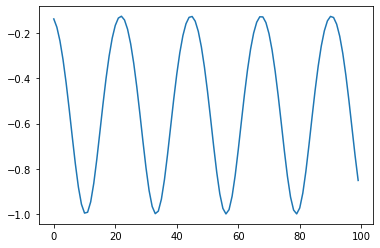

In [5]:
obs.shape
plt.plot(obs[:100, 0])

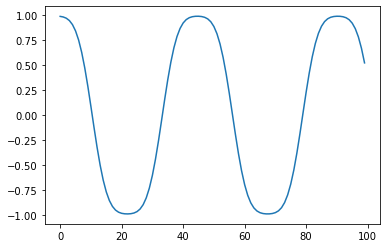

In [6]:
plt.plot(obs[:100, 1])

In [14]:
dx0 = dxs0 = (obs[1, :2] - obs[0, :2]) / 0.05
x0 = obs[0, :2]

x_dx0 = torch.unsqueeze(torch.cat([x0, dxs0], dim=0), dim=0)
t_span = torch.linspace(0, 0.05*1000, 1000)
est = learn.forward(x_dx0.float(), t_span)

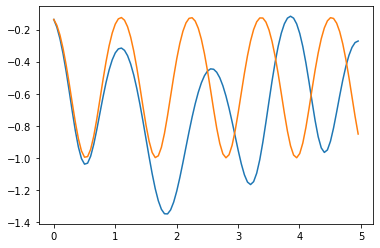

In [17]:
plt.plot(t_span.detach().numpy()[:100], est[:100, 0, 0].detach().numpy())
plt.plot(t_span.detach().numpy()[:100], obs[:100, 0])
plt.show()

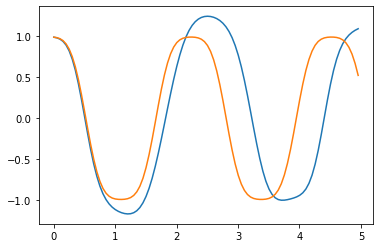

In [18]:
plt.plot(t_span.detach().numpy()[:100], est[:100, 0, 1].detach().numpy())
plt.plot(t_span.detach().numpy()[:100], obs[:100, 1])

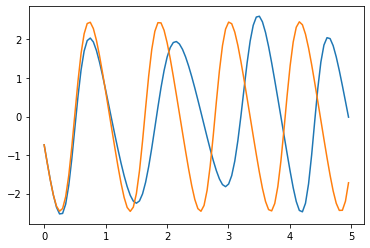

In [20]:
plt.plot(t_span.detach().numpy()[:100], est[:100, 0, 2].detach().numpy())
plt.plot(t_span.detach().numpy()[:100], (obs[1:101, 0] - obs[0:100, 0])/0.05)


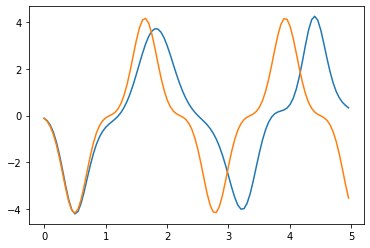

In [21]:
plt.plot(t_span.detach().numpy()[:100], est[:100, 0, 3].detach().numpy())
plt.plot(t_span.detach().numpy()[:100], (obs[1:101, 1] - obs[0:100, 1])/0.05)


In [ ]:
L1 = est[:, 0, 0] + est[:, 0, 1] * 10 + (est[:, 0, 2] ** 2 + est[:, 0, 3] ** 2) / 2
plt.plot(t_span.detach().numpy()[:100], L1.detach().numpy())

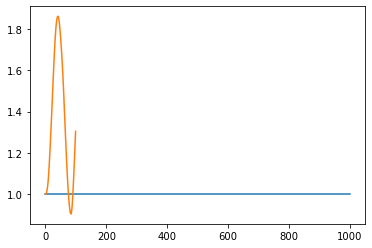

In [13]:
test1 = obs[:, 0] **2 + obs[:, 1] **2
test2 = est[:, 0, 0] ** 2 + est[:, 0, 1] ** 2
plt.plot(test1)
plt.plot(test2.detach().numpy())